In [0]:
import os
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
import xgboost as xgb
import matplotlib.pyplot as plt

In [0]:
def fundamental_model_analysis(store_name, events, sales, is_annual=False):
  
  events_base = events.drop(columns=['title', 'description', 'labels', 
                                     'venue_name', 'longitude', 'latitude', 
                                     'local_rank', 'aviation_rank'])
  
  df = pd.merge(events_base, sales[['sales_cleaned', 'date']], on='date')

  df = df.dropna()

  if is_annual == True:
    df = df[df.is_annual == 1]

  X = df.drop(columns=['sales_cleaned', 'date'])
  y = df['sales_cleaned']

  def compute_f(X_trans, y, feature_names):
    F, p = f_regression(X_trans, y)
    F_test = pd.DataFrame(zip(feature_names, F, p), 
                      columns = ['feature', 'F-score', 'p-value']).sort_values('F-score', ascending = False)
    return F_test

  def fit_model(X, y):
    categorical = X.dtypes == object
    preprocess = make_column_transformer(
    (make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), 
                   MaxAbsScaler()), ~categorical),
    (OneHotEncoder(handle_unknown='ignore'), categorical)) 

    X_trans = preprocess.fit_transform(X)

    F_test = compute_f(X_trans, y, pd.get_dummies(X).columns)
    
    baseline = LinearRegression(normalize=True)
    xgbrg = xgb.XGBRegressor(n_estimators=500, max_depth = 20)
    
    baseline.fit(X_trans, y)
    xgbrg.fit(X_trans, y)
    # print(rg.score(X_trans, y))
    return X_trans, F_test, baseline, xgbrg

  def plot_imp(model, feature_names, linear=True):
    
    if linear:
      coef = model.coef_
    else: 
      coef = model.feature_importances_

    coef_idx = np.argsort(coef)[::-1]

    colors=['red'if c > 0 else 'blue' for c in np.sort(-coef)]

    _ = plt.figure(figsize=(12, 8))
    _ = plt.bar([feature_names[i] for i in coef_idx], height=np.sort(coef)[::-1], color=colors)
    _ = plt.xlabel('Features')
    _ = plt.ylabel('Coefficients')
    if linear:
      _ = plt.title('Coefficients for Baseline Linear Regression Model\n' +
                  store_name)
      filename = 'baseline_result.png'
    else:
      _ = plt.title('Features for XGB Regression Model\n' +
                  store_name)
      filename = 'xgb_result.png'

    _ = plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(path + '/' + filename)
    plt.show()

  path = store_name + ' Fundamental Model Analysis'
  if not os.path.exists(path):
    os.mkdir(path)
  
  feature_names = pd.get_dummies(X).columns
  X_trans, F_test, baseline, xgbrg = fit_model(X, y)
  
  print(F_test[F_test['p-value'] <= 0.1])
  F_test.to_csv(os.path.join(path, 'F_test.csv'))
  
  plot_imp(baseline, feature_names)
  
  plot_imp(xgbrg, feature_names, linear=False)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[04:05:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
               feature   F-score  p-value
27  venue_type_outdoor  2.873212  0.09008
26   venue_type_indoor  2.873212  0.09008


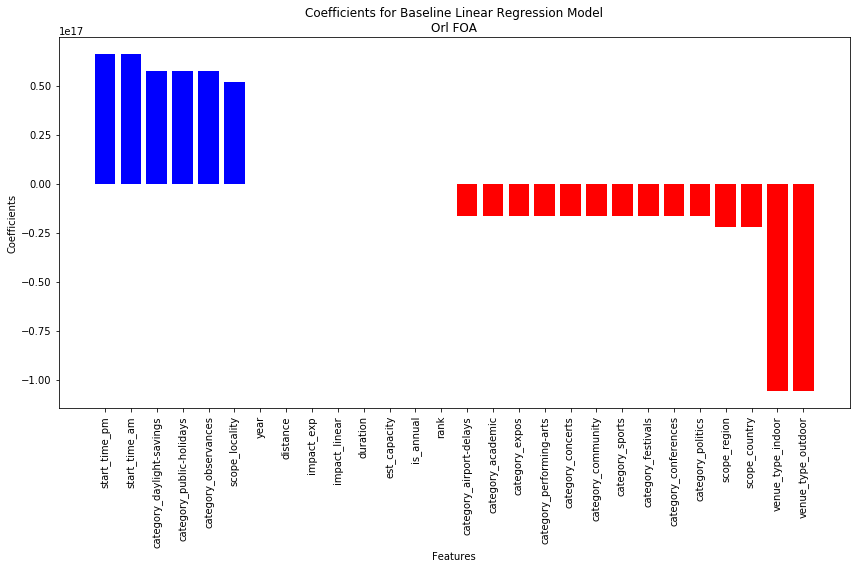

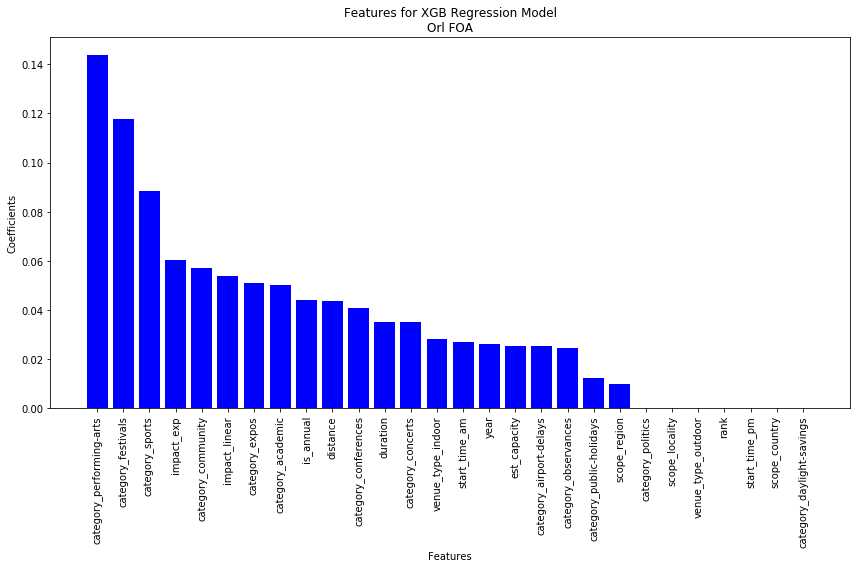

In [12]:
fundamental_model_analysis('Orl FOA', events, sales)